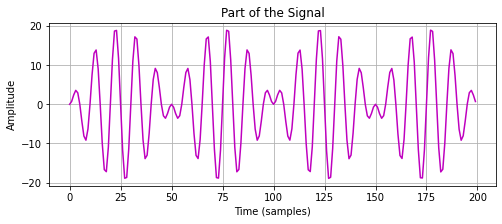

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# 
# Adaptive Noise Cancellation using Least Mean Squares Algorithm
# Example for COMP6247: Reinforcement and Online Learning
#
# Mahesan Niranjan
# University of Southampton, February 2021
#

FundamentalFrequency = 1000
SignalFrequency      = 100
SamplingFrequency    = 10000

# Amplitude of carrier (fundamental?)
#
A = 10

# Sampling period, number of seconds to synthesize and time axis (samples)
#
SamplingPeriod = 1./ SamplingFrequency
T  = 1
TimeAxis = np.linspace(0, T, int(T/SamplingPeriod)).reshape([-1,1]);

# Generate synthetic signal
#
ModulatingSignal =  2*np.sin(2*np.pi*SignalFrequency*TimeAxis)
Fundamental      = 10*np.sin(2*np.pi*FundamentalFrequency*TimeAxis)
signal           = Fundamental*ModulatingSignal
N = signal.shape[0]

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(signal[0:200], c="m")
ax.set_title("Part of the Signal")
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Amplitude")
ax.grid(True)

In [9]:
# White noise is Gaussian random numbers
#
WhiteNoise = 0.4*np.max(signal)*np.random.randn(N,1)

[[ 0.02191191  0.02135107  0.18746487  0.94073789 -0.10763634  0.25951409]]


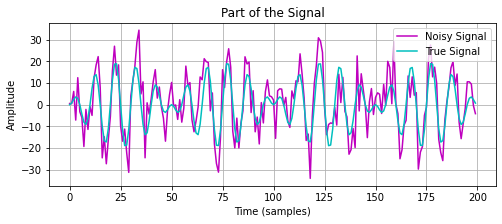

In [10]:
FilterOrder = 6
wTrue = np.random.randn(FilterOrder,1)
wTrue /= np.linalg.norm(wTrue)

# The true filter (what happens in the meduim)
#
print(wTrue.T)

# Generate coloured noise by filtering white noise
#
FilteredNoise = WhiteNoise.copy()
for n in (np.arange(FilterOrder+1,N-1)):
    PastValues  = WhiteNoise[n-FilterOrder-1:n-1,:]
    wnh = PastValues .T @ wTrue
    FilteredNoise[n] = wnh

# Add noise to signal
#
NoisySignal = FilteredNoise + signal

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(NoisySignal[0:200,0], c="m",label="Noisy Signal")
ax.plot(signal[0:200,0], c="c", label="True Signal")
ax.set_title("Part of the Signal")
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Amplitude")
ax.grid(True)
plt.legend()

In [11]:
# Listen to the true signal, disturbing noise and the noisy signal
#
from IPython.display import Audio
Audio(np.concatenate((signal[:,0], FilteredNoise[:,0], NoisySignal[:,0]), axis=0), rate=SamplingFrequency)

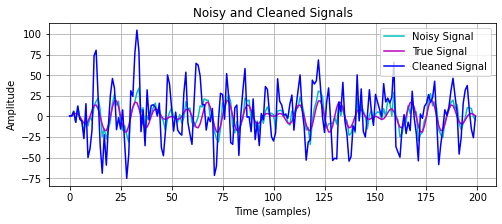

In [12]:
# Lets assume we know the filter order: FilterOrder
#
InitialWeights = np.random.randn(FilterOrder,1)
CleanedSignal  = NoisySignal.copy()

# Learning Rate for LMS update
#
eta = 0.2e-4

# Initialize weights
#
Weights = InitialWeights 

# Save space to retain all updates to plot to observe convergence
#
AllWeights = np.zeros((FilterOrder,N))
for n in range(N):
    AllWeights[:,n] = Weights [:,0]

# Adaptive noise canceller with LMS
#
for n in (np.arange(FilterOrder+1,N-1)):

    PastValues = WhiteNoise[n-FilterOrder-1:n-1,:]
    EstimatedNoise =  PastValues.T @ Weights 
    
    # Update is constant times error times input
    #
    Weights  -= eta * (EstimatedNoise - NoisySignal[n,0]) * PastValues 
    
    # Save the weights
    #
    AllWeights[:,n] = Weights [:,0]

    # Estimated clean signal is difference between noisy signal and predicted noise
    #
    CleanedSignal[n,0] = NoisySignal[n,0] - EstimatedNoise 

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(NoisySignal[0:200], c="c", label="Noisy Signal")
ax.plot(signal[0:200], c="m", label="True Signal")
ax.plot(CleanedSignal[0:200], c="b", label = "Cleaned Signal")
ax.set_title("Noisy and Cleaned Signals")
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Amplitude")
ax.grid(True)
plt.legend()

Text(0, 0.5, 'Amplitude')

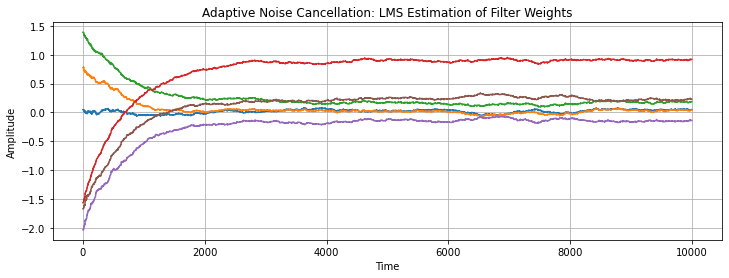

In [13]:
# Plot to see how the weights converged
#
fig, ax = plt.subplots(figsize=(12,4))
for j in range(FilterOrder):
    ax.plot(np.arange(N-1), AllWeights[j,0:N-1])
ax.grid(True)
ax.set_title("Adaptive Noise Cancellation: LMS Estimation of Filter Weights")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")

In [14]:
# Listen to the noisy and cleaned up signals
#
Audio(np.concatenate((NoisySignal[:,0], CleanedSignal[:,0]), axis=0), rate=SamplingFrequency)